<a href="https://colab.research.google.com/github/Hubert26/suicides_IPPAN/blob/main/suicides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Liblaries and settings

In [351]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None

np.random.seed(42)

#Function definitions

In [352]:
def display_info(df, selected_columns):
    print(selected_columns)
    print(len(selected_columns))
    for col_name in selected_columns:

        # Mode
        print("\nMode:")
        print(df[col_name].mode())

        # NaN count
        nan_count = df[col_name].isna().sum()
        print("\nNaN count:", nan_count)

        # Unique values len
        print("\nUnique values len:")
        print(len(df[col_name].unique()))

        # Unique values
        print("\nUnique values:")
        print(df[col_name].unique())

        # Value counts
        print("\nValue counts:")
        print(df[col_name].value_counts())

        print("\n" + "=" * 40)  # Separator between columns


In [353]:
def create_bar_plot(x_values, y_values, x_label, y_label, title, x_rotation=0):

    # Tworzenie wykresu słupkowego
    plt.bar(x_values, y_values)

    # Dodanie wartości nad słupkami
    for i in range(len(x_values)):
        plt.text(x_values[i], y_values[i], str(y_values[i]), ha='center', va='bottom')

    # Dodanie tytułu i etykiet osi
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Wyświetlenie wykresu
    plt.xticks(rotation=x_rotation, ha='right')
    plt.tight_layout()
    plt.show()


#Data exploration

In [354]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/suicides_IPPAN/main/data/df_data.csv', delimiter=',', low_memory=False)

In [355]:
df_raw.head()

,suicide_id,report_date_year,report_date_month,age_group,gender,marital_status,education,work_study_info,livelihood_source,is_fatal,location_of_attack,method_of_committing,consciousness_state,substance_info,treatment_info,"reasons_of_attack_Bullying, cyberbullying, harassment",reasons_of_attack_Chronic illness,reasons_of_attack_Committing a crime or misdemeanor,reasons_of_attack_Conflict with non-family members,reasons_of_attack_Death of a close person,reasons_of_attack_Deterioration or sudden loss of health,reasons_of_attack_Family misunderstanding/family violence,"reasons_of_attack_HIV carrier, AIDS patient",reasons_of_attack_Love affair,reasons_of_attack_Mental illness/mental disorders,reasons_of_attack_Other unspecified,reasons_of_attack_Permanent disability,reasons_of_attack_Physical illness,reasons_of_attack_Poor economic conditions/debt,reasons_of_attack_School or work problems,reasons_of_attack_Sudden loss of livelihood,reasons_of_attack_Threat or loss of housing,reasons_of_attack_Unwanted pregnancy,reason_of_attack_count
0,114 581 552,2013,1,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,114 584 284,2013,1,13-18,male,NaN,NaN,Student,NaN,1.0,Road/street/sidewalk,Throwing oneself under a moving vehicle,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,114 584 293,2013,1,13-18,female,Single,Primary education,Student,Dependent on another person,1.0,Other,Jumping from a height,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,114 584 312,2013,1,19-24,male,Single,NaN,NaN,NaN,1.0,NaN,Other,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,114 584 399,2013,1,40-44,male,Single,NaN,Unemployed,NaN,1.0,Outbuildings,Hanging,Under the influence of alcohol,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [356]:
selected_columns = [
    'reasons_of_attack_Bullying, cyberbullying, harassment',
    'reasons_of_attack_Chronic illness',
    'reasons_of_attack_Committing a crime or misdemeanor',
    'reasons_of_attack_Conflict with non-family members',
    'reasons_of_attack_Death of a close person',
    'reasons_of_attack_Deterioration or sudden loss of health',
    'reasons_of_attack_Family misunderstanding/family violence',
    'reasons_of_attack_HIV carrier, AIDS patient',
    'reasons_of_attack_Love affair',
    'reasons_of_attack_Mental illness/mental disorders',
    'reasons_of_attack_Other unspecified',
    'reasons_of_attack_Permanent disability',
    'reasons_of_attack_Physical illness',
    'reasons_of_attack_Poor economic conditions/debt',
    'reasons_of_attack_School or work problems',
    'reasons_of_attack_Sudden loss of livelihood',
    'reasons_of_attack_Threat or loss of housing',
    'reasons_of_attack_Unwanted pregnancy'
]

df_data = df_raw.drop(columns=selected_columns)
df_data_reasons_of_attack = df_raw[selected_columns]

In [357]:
df_data['reason_of_attack_count'] = df_data['reason_of_attack_count'].replace(0, np.nan)

##NaN exploration in variables

In [358]:
df_data.shape

(113196, 16)

In [359]:
df_data[df_data['suicide_id'].duplicated()].suicide_id #Sprawdzenie duplikatów

Series([], Name: suicide_id, dtype: object)

In [360]:
##Brakujące dane
total = df_data.isnull().sum().sort_values(ascending=False)
percent = 100*(df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [361]:
missing_data

,Total,Percent
treatment_info,108281,95.657974
substance_info,93753,82.823598
education,77929,68.844305
consciousness_state,58827,51.969151
work_study_info,55930,49.409873
livelihood_source,49338,43.586346
reason_of_attack_count,40058,35.388176
marital_status,14345,12.672709
age_group,1288,1.137849
location_of_attack,106,0.093643


##NaN exploration in rows

In [362]:
nan_counts = df_data.isna().sum(axis=1).value_counts()

In [363]:
full_index = list(range(0, len(df_data.columns.tolist()) + 1))

# Zsumowanie istniejących wartości z pełną listą i ustawienie brakujących wartości na 0
nan_counts = nan_counts.reindex(full_index, fill_value=0)

# Sortowanie wyników rosnąco
nan_counts = nan_counts.sort_index()

In [364]:
nan_counts_proc = (nan_counts / len(df_data)) * 100

In [365]:
missing_data_rows = pd.concat([nan_counts, nan_counts_proc], axis=1, keys=['Total', 'Percent'])
missing_data_rows

,Total,Percent
0,83,0.073324
1,3873,3.421499
2,15283,13.501360
3,19126,16.896357
4,19919,17.596912
5,21450,18.949433
6,17743,15.674582
7,11497,10.156719
8,3882,3.429450
9,263,0.232340


In [366]:
# Usunięcie wierszy z df_data i df_data_reasons_of_attack gdzie są NaN w 'gender' i 'age_group'
selected_index = df_data[df_data['gender'].isna() | df_data['age_group'].isna()].index

df_data = df_data.drop(index=selected_index)
df_data_reasons_of_attack = df_data_reasons_of_attack.drop(index=selected_index)

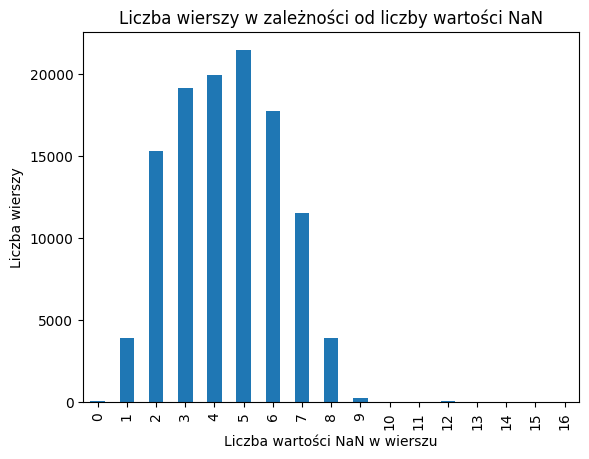

In [367]:
# Tworzenie wykresu kolumnowego
nan_counts.plot(kind='bar')

# Dodanie tytułu i etykiet osi
plt.title('Liczba wierszy w zależności od liczby wartości NaN')
plt.xlabel('Liczba wartości NaN w wierszu')
plt.ylabel('Liczba wierszy')

# Wyświetlenie wykresu
plt.show()

##data_age_groups

In [368]:
sorted(list(set(df_data['age_group'])))


['13-18',
 '19-24',
 '25-29',
 '30-34',
 '35-39',
 '40-44',
 '45-49',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '7-12',
 '70-74',
 '75-79',
 '80-84',
 '85+']

###data_age_group_7-12

In [369]:
age_group = '7-12'

In [370]:
selected_index = df_data.loc[df_data['age_group'] == age_group].index

In [371]:
data_age_group_7_12 = df_data.loc[selected_index]
data_age_group_7_12_reasons_of_attack = df_data_reasons_of_attack.loc[selected_index]

In [372]:
data_age_group_7_12.shape

(343, 16)

####NaN exploration in variables

In [373]:
##Brakujące dane
total = data_age_group_7_12.isnull().sum().sort_values(ascending=False)
percent = 100*(data_age_group_7_12.isnull().sum()/data_age_group_7_12.isnull().count()).sort_values(ascending=False)
missing_data_age_group_7_12 = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [374]:
missing_data_age_group_7_12

,Total,Percent
substance_info,343,100.000000
treatment_info,343,100.000000
consciousness_state,120,34.985423
reason_of_attack_count,85,24.781341
education,44,12.827988
livelihood_source,17,4.956268
work_study_info,12,3.498542
marital_status,6,1.749271
suicide_id,0,0.000000
report_date_year,0,0.000000


####NaN exploration in rows

In [375]:
nan_counts = data_age_group_7_12.isna().sum(axis=1).value_counts()

In [376]:
full_index = list(range(0, len(data_age_group_7_12.columns.tolist()) + 1))

# Zsumowanie istniejących wartości z pełną listą i ustawienie brakujących wartości na 0
nan_counts = nan_counts.reindex(full_index, fill_value=0)

# Sortowanie wyników rosnąco
nan_counts = nan_counts.sort_index()

In [377]:
nan_counts_proc = (nan_counts / len(data_age_group_7_12)) * 100

In [378]:
missing_data_rows = pd.concat([nan_counts, nan_counts_proc], axis=1, keys=['Total', 'Percent'])
missing_data_rows

,Total,Percent
0,0,0.000000
1,0,0.000000
2,158,46.064140
3,116,33.819242
4,46,13.411079
5,17,4.956268
6,5,1.457726
7,1,0.291545
8,0,0.000000
9,0,0.000000


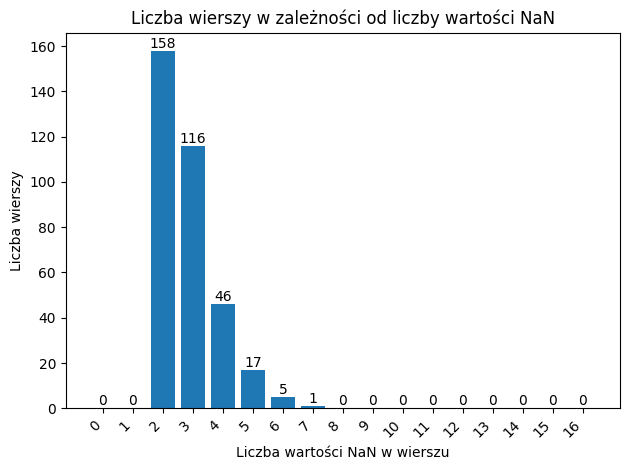

In [379]:
create_bar_plot(nan_counts.reset_index().iloc[:, 0].astype(str).tolist(),
                nan_counts.reset_index().iloc[:, 1].tolist(),
                'Liczba wartości NaN w wierszu',
                'Liczba wierszy',
                'Liczba wierszy w zależności od liczby wartości NaN',
                x_rotation=45)

In [380]:
# data_age_group_7_12 = data_age_group_7_12[data_age_group_7_12.isna().sum(axis=1) <= 8]

####Variable - consciousness_state

In [381]:
variable = 'consciousness_state'

In [382]:
display_info(data_age_group_7_12, [variable])

['consciousness_state']
1

Mode:
0    Sober
Name: consciousness_state, dtype: object

NaN count: 120

Unique values len:
8

Unique values:
['Under the influence of alcohol' 'Sober' nan
 'Under the influence of psychotropic substances (drugs, etc.)'
 'Under the influence of substitute substances (legal highs)'
 'Under the influence of medications' 'Under the influence of intoxicants'
 'Under the influence of alcohol and medications']

Value counts:
Sober                                                           166
Under the influence of medications                               45
Under the influence of alcohol                                    6
Under the influence of intoxicants                                3
Under the influence of psychotropic substances (drugs, etc.)      1
Under the influence of substitute substances (legal highs)        1
Under the influence of alcohol and medications                    1
Name: consciousness_state, dtype: int64



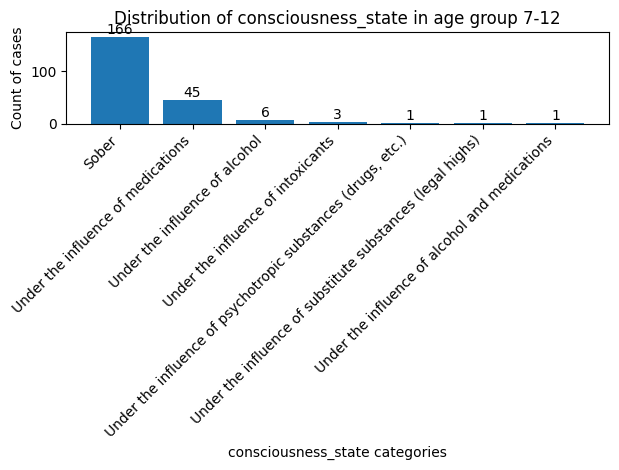

In [383]:
create_bar_plot(data_age_group_7_12_raw[variable].dropna().value_counts().index,
                data_age_group_7_12_raw[variable].dropna().value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####gender

In [384]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].dropna().groupby('gender')[variable].value_counts()


In [385]:
value_counts_df

gender  consciousness_state                                         
female  Sober                                                           113
        Under the influence of medications                               44
        Under the influence of alcohol                                    3
        Under the influence of intoxicants                                2
        Under the influence of alcohol and medications                    1
        Under the influence of substitute substances (legal highs)        1
male    Sober                                                            53
        Under the influence of alcohol                                    3
        Under the influence of intoxicants                                1
        Under the influence of medications                                1
        Under the influence of psychotropic substances (drugs, etc.)      1
Name: consciousness_state, dtype: int64

In [386]:
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

######female

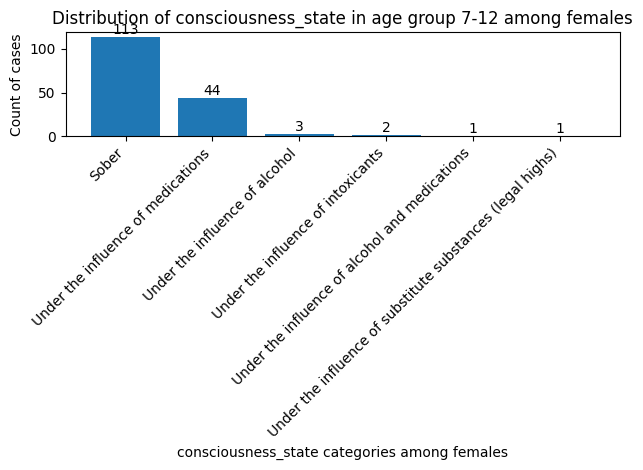

In [387]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [388]:
female_probabilities = female_series / sum(female_series)

In [389]:
female_probabilities

consciousness_state
Sober                                                         0.689024
Under the influence of medications                            0.268293
Under the influence of alcohol                                0.018293
Under the influence of intoxicants                            0.012195
Under the influence of alcohol and medications                0.006098
Under the influence of substitute substances (legal highs)    0.006098
Name: consciousness_state, dtype: float64

In [390]:
female_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'female')

In [391]:
data_age_group_7_12.loc[female_null_mask, variable] = np.random.choice(list(female_probabilities.index), size=female_null_mask.sum(), p=list(female_probabilities.values))


######male

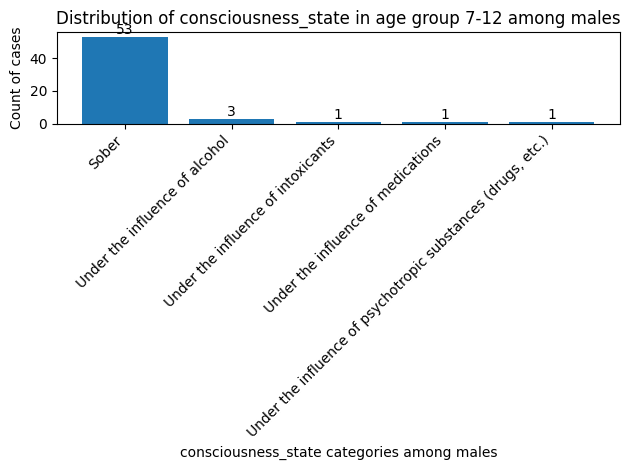

In [392]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

In [393]:
male_probabilities = male_series / sum(male_series)

In [394]:
male_probabilities

consciousness_state
Sober                                                           0.898305
Under the influence of alcohol                                  0.050847
Under the influence of intoxicants                              0.016949
Under the influence of medications                              0.016949
Under the influence of psychotropic substances (drugs, etc.)    0.016949
Name: consciousness_state, dtype: float64

In [395]:
male_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'male')

In [396]:
data_age_group_7_12.loc[male_null_mask, variable] = np.random.choice(list(male_probabilities.index), size=male_null_mask.sum(), p=list(male_probabilities.values))


#####Summary

In [397]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].groupby('gender')[variable].value_counts()
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

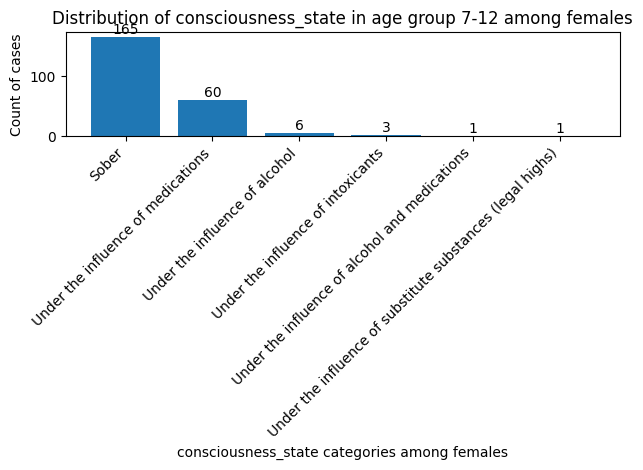

In [398]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

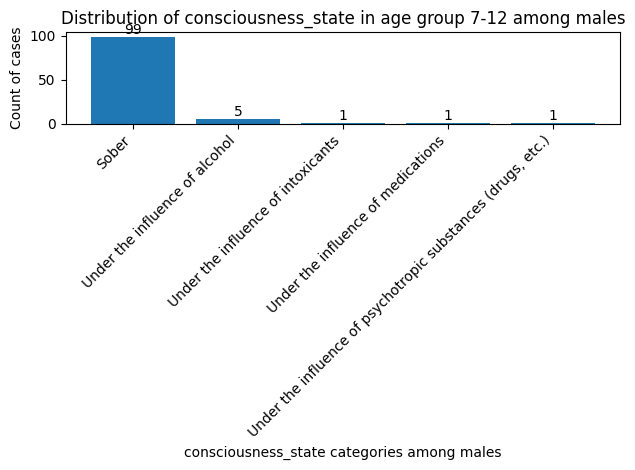

In [399]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

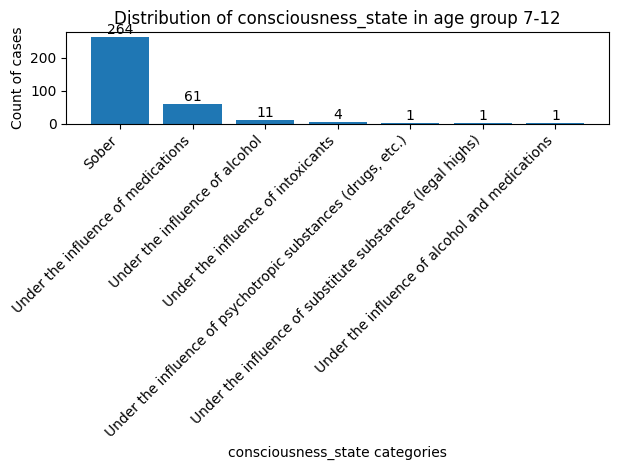

In [400]:
create_bar_plot(data_age_group_7_12[variable].value_counts().index,
                data_age_group_7_12[variable].value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - education

In [401]:
variable = 'education'

In [402]:
display_info(data_age_group_7_12, [variable])

['education']
1

Mode:
0    Incomplete primary education
Name: education, dtype: object

NaN count: 44

Unique values len:
4

Unique values:
['Primary education' 'Incomplete primary education' nan
 'Lower secondary education']

Value counts:
Incomplete primary education    194
Primary education               103
Lower secondary education         2
Name: education, dtype: int64



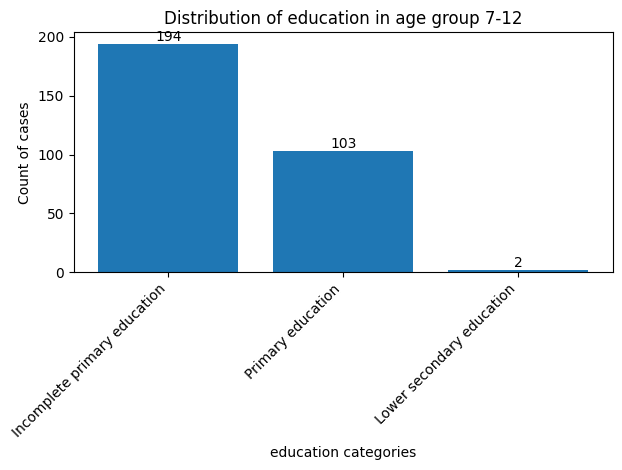

In [403]:
create_bar_plot(data_age_group_7_12_raw[variable].dropna().value_counts().index,
                data_age_group_7_12_raw[variable].dropna().value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####gender

In [404]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].dropna().groupby('gender')[variable].value_counts()


In [405]:
value_counts_df

gender  education                   
female  Incomplete primary education    137
        Primary education                69
        Lower secondary education         2
male    Incomplete primary education     57
        Primary education                34
Name: education, dtype: int64

In [406]:
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

######female

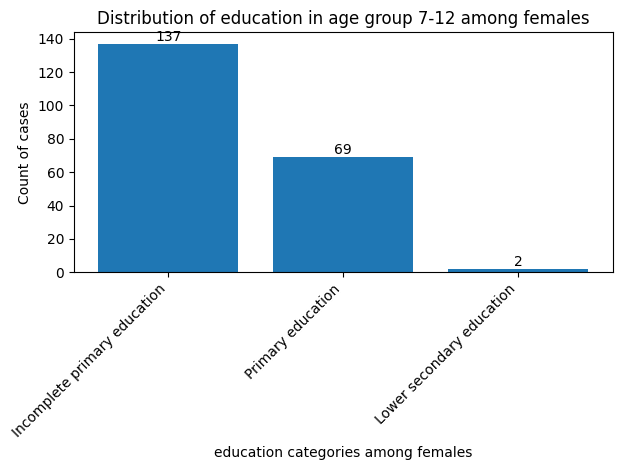

In [407]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [408]:
female_probabilities = female_series / sum(female_series)

In [409]:
female_probabilities

education
Incomplete primary education    0.658654
Primary education               0.331731
Lower secondary education       0.009615
Name: education, dtype: float64

In [410]:
female_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'female')

In [411]:
data_age_group_7_12.loc[female_null_mask, variable] = np.random.choice(list(female_probabilities.index), size=female_null_mask.sum(), p=list(female_probabilities.values))


######male

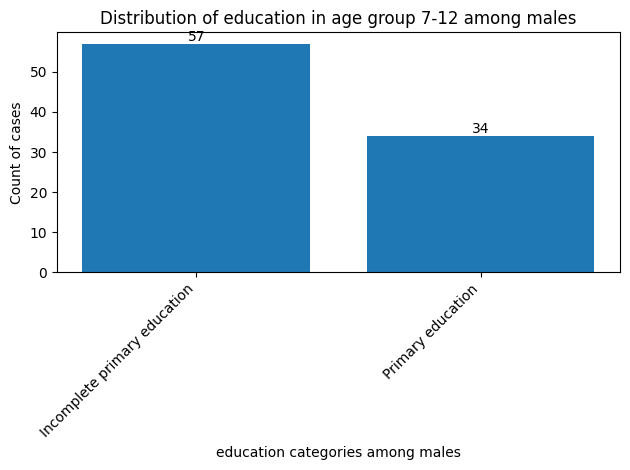

In [412]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

In [413]:
male_probabilities = male_series / sum(male_series)

In [414]:
male_probabilities

education
Incomplete primary education    0.626374
Primary education               0.373626
Name: education, dtype: float64

In [415]:
male_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'male')

In [416]:
data_age_group_7_12.loc[male_null_mask, variable] = np.random.choice(list(male_probabilities.index), size=male_null_mask.sum(), p=list(male_probabilities.values))


#####Summary

In [417]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].groupby('gender')[variable].value_counts()
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

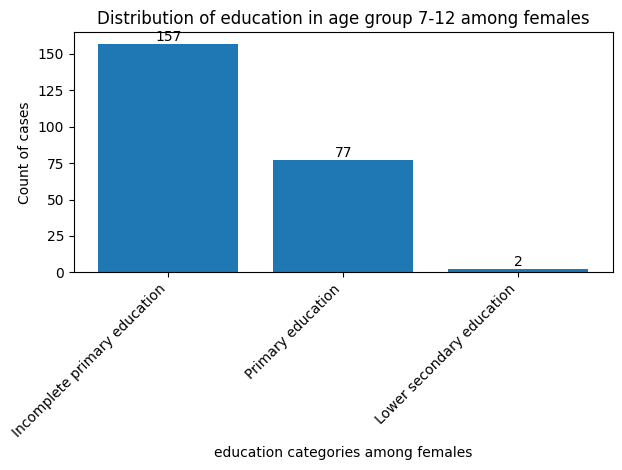

In [418]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

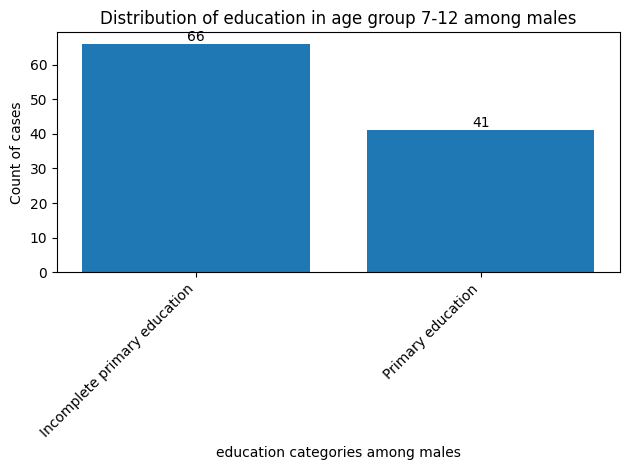

In [419]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

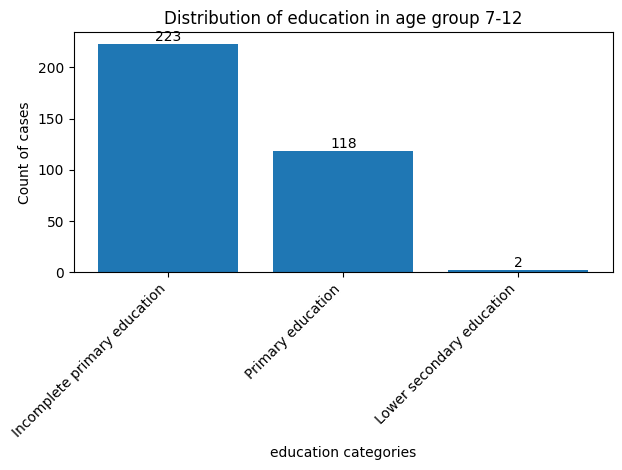

In [420]:
create_bar_plot(data_age_group_7_12[variable].value_counts().index,
                data_age_group_7_12[variable].value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - livelihood_source

In [421]:
variable = 'livelihood_source'

In [422]:
display_info(data_age_group_7_12, [variable])

['livelihood_source']
1

Mode:
0    Dependent on another person
Name: livelihood_source, dtype: object

NaN count: 17

Unique values len:
4

Unique values:
['Dependent on another person' nan 'Employed'
 'No regular source of maintenance']

Value counts:
Dependent on another person         323
No regular source of maintenance      2
Employed                              1
Name: livelihood_source, dtype: int64



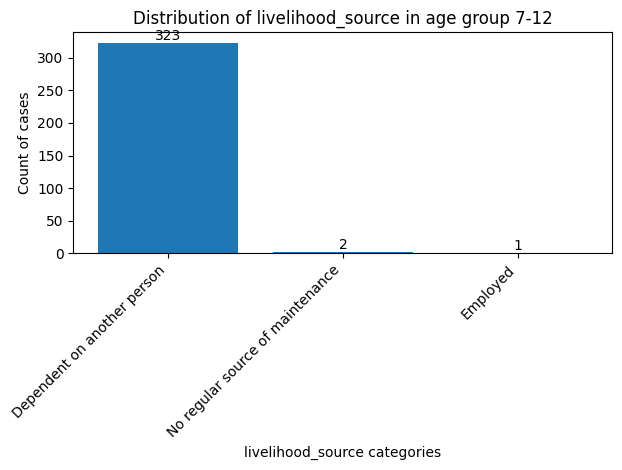

In [423]:
create_bar_plot(data_age_group_7_12_raw[variable].dropna().value_counts().index,
                data_age_group_7_12_raw[variable].dropna().value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####gender

In [424]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].dropna().groupby('gender')[variable].value_counts()


In [425]:
value_counts_df

gender  livelihood_source               
female  Dependent on another person         223
        No regular source of maintenance      2
male    Dependent on another person         100
        Employed                              1
Name: livelihood_source, dtype: int64

In [426]:
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

######female

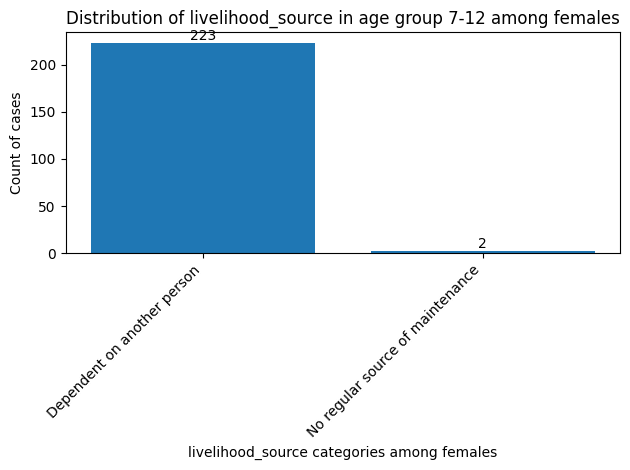

In [427]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [428]:
female_probabilities = female_series / sum(female_series)

In [429]:
female_probabilities

livelihood_source
Dependent on another person         0.991111
No regular source of maintenance    0.008889
Name: livelihood_source, dtype: float64

In [430]:
female_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'female')

In [431]:
data_age_group_7_12.loc[female_null_mask, variable] = np.random.choice(list(female_probabilities.index), size=female_null_mask.sum(), p=list(female_probabilities.values))


######male

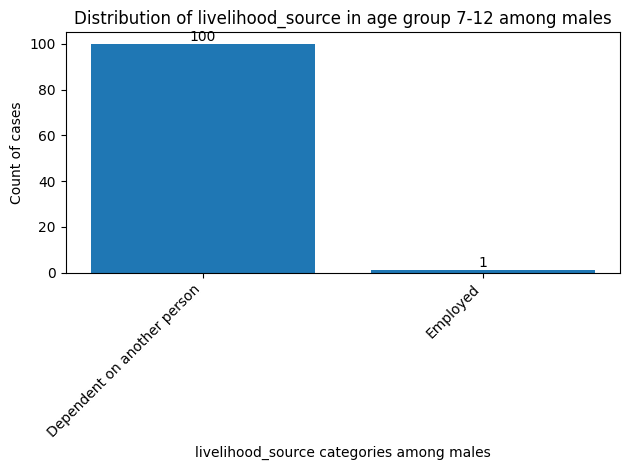

In [432]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

In [433]:
male_probabilities = male_series / sum(male_series)

In [434]:
male_probabilities

livelihood_source
Dependent on another person    0.990099
Employed                       0.009901
Name: livelihood_source, dtype: float64

In [435]:
male_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'male')

In [436]:
data_age_group_7_12.loc[male_null_mask, variable] = np.random.choice(list(male_probabilities.index), size=male_null_mask.sum(), p=list(male_probabilities.values))


#####Summary

In [437]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].groupby('gender')[variable].value_counts()
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

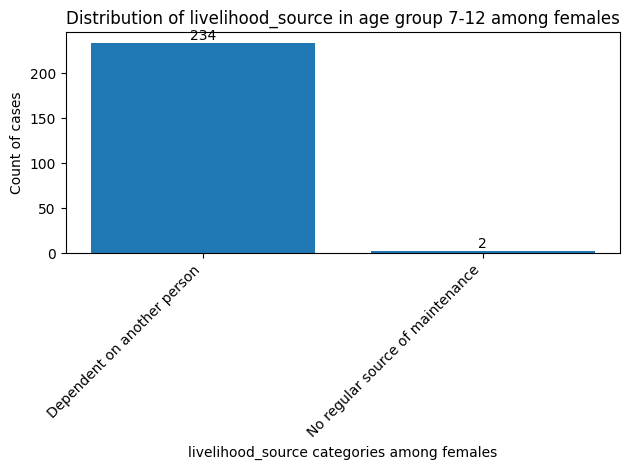

In [438]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

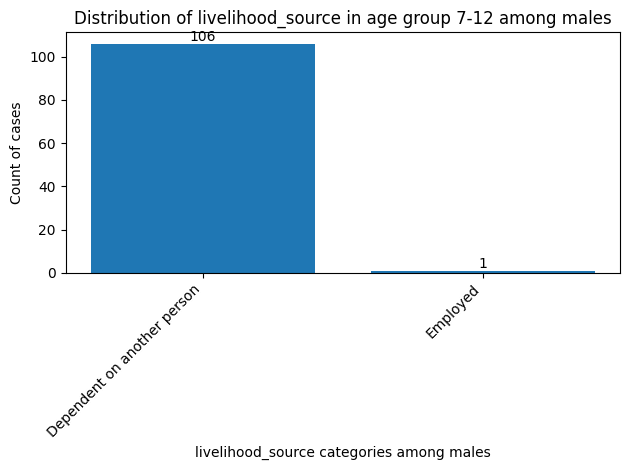

In [439]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

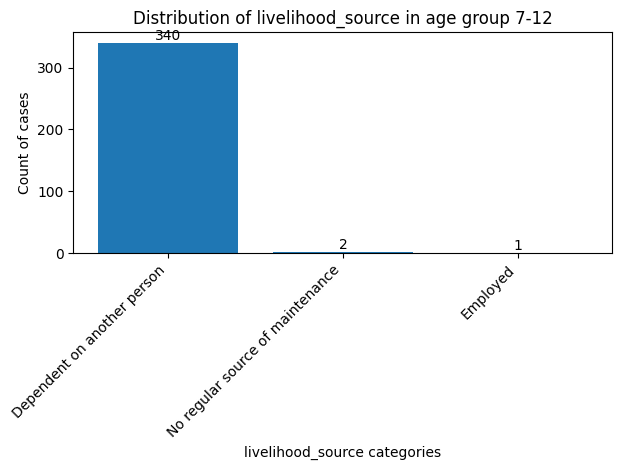

In [440]:
create_bar_plot(data_age_group_7_12[variable].value_counts().index,
                data_age_group_7_12[variable].value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - work_study_info

In [441]:
variable = 'work_study_info'

In [442]:
display_info(data_age_group_7_12, [variable])

['work_study_info']
1

Mode:
0    Student
Name: work_study_info, dtype: object

NaN count: 12

Unique values len:
4

Unique values:
['Student' 'Blue-collar worker' nan 'Unemployed']

Value counts:
Student               329
Blue-collar worker      1
Unemployed              1
Name: work_study_info, dtype: int64



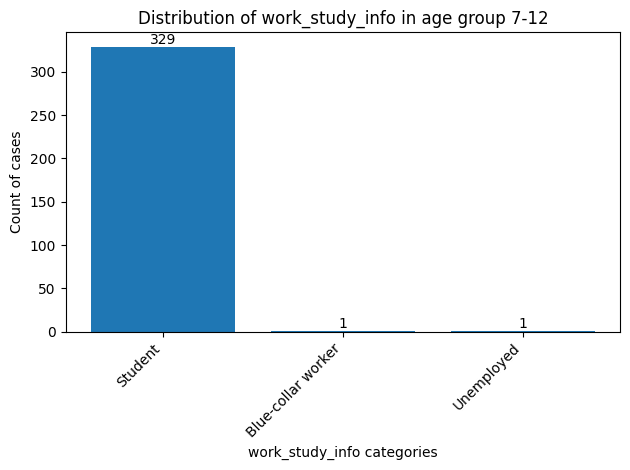

In [443]:
create_bar_plot(data_age_group_7_12_raw[variable].dropna().value_counts().index,
                data_age_group_7_12_raw[variable].dropna().value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####gender

In [444]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].dropna().groupby('gender')[variable].value_counts()


In [445]:
value_counts_df

gender  work_study_info   
female  Student               227
male    Student               102
        Blue-collar worker      1
        Unemployed              1
Name: work_study_info, dtype: int64

In [446]:
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

######female

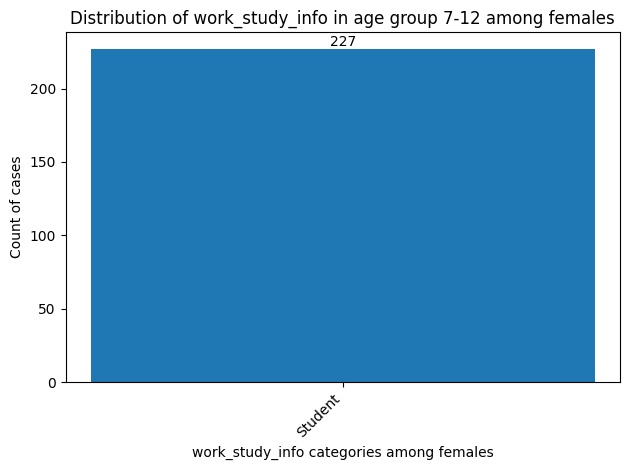

In [447]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [448]:
female_probabilities = female_series / sum(female_series)

In [449]:
female_probabilities

work_study_info
Student    1.0
Name: work_study_info, dtype: float64

In [450]:
female_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'female')

In [451]:
data_age_group_7_12.loc[female_null_mask, variable] = np.random.choice(list(female_probabilities.index), size=female_null_mask.sum(), p=list(female_probabilities.values))


######male

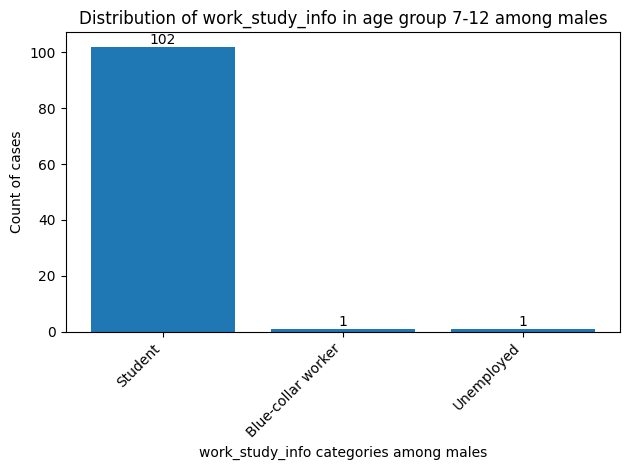

In [452]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

In [453]:
male_probabilities = male_series / sum(male_series)

In [454]:
male_probabilities

work_study_info
Student               0.980769
Blue-collar worker    0.009615
Unemployed            0.009615
Name: work_study_info, dtype: float64

In [455]:
male_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'male')

In [456]:
data_age_group_7_12.loc[male_null_mask, variable] = np.random.choice(list(male_probabilities.index), size=male_null_mask.sum(), p=list(male_probabilities.values))


#####Summary

In [457]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].groupby('gender')[variable].value_counts()
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

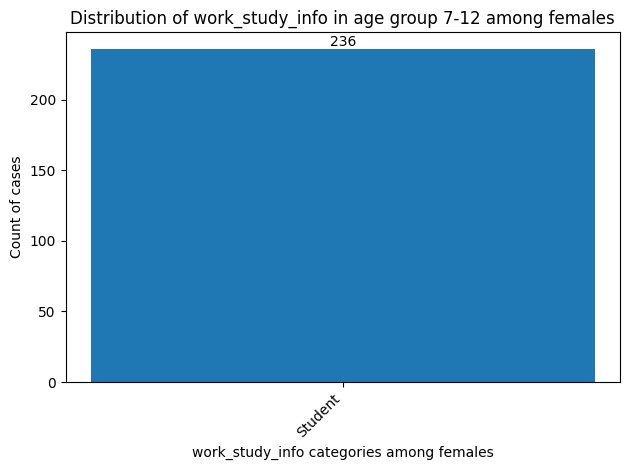

In [458]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

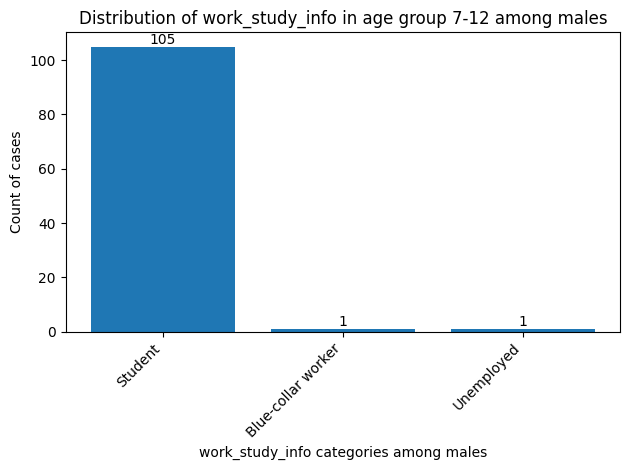

In [459]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

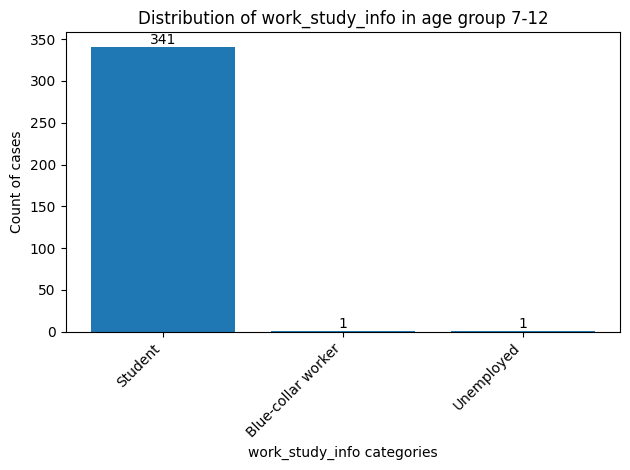

In [460]:
create_bar_plot(data_age_group_7_12[variable].value_counts().index,
                data_age_group_7_12[variable].value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - marital_status

In [461]:
variable = 'marital_status'

In [462]:
display_info(data_age_group_7_12, [variable])

['marital_status']
1

Mode:
0    Single
Name: marital_status, dtype: object

NaN count: 6

Unique values len:
2

Unique values:
['Single' nan]

Value counts:
Single    337
Name: marital_status, dtype: int64



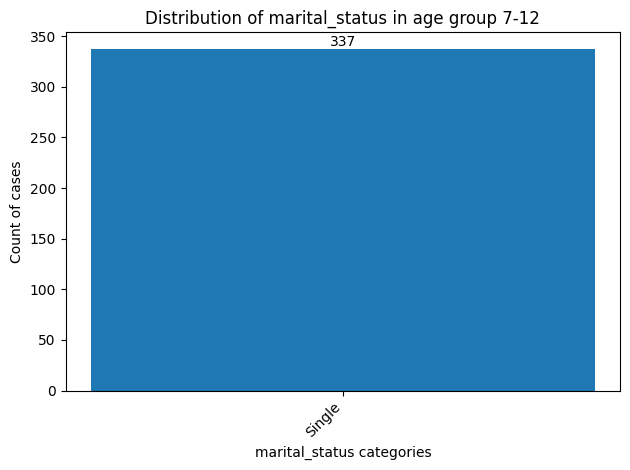

In [463]:
create_bar_plot(data_age_group_7_12_raw[variable].dropna().value_counts().index,
                data_age_group_7_12_raw[variable].dropna().value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####gender

In [464]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].dropna().groupby('gender')[variable].value_counts()


In [465]:
value_counts_df

gender  marital_status
female  Single            231
male    Single            106
Name: marital_status, dtype: int64

In [466]:
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

######female

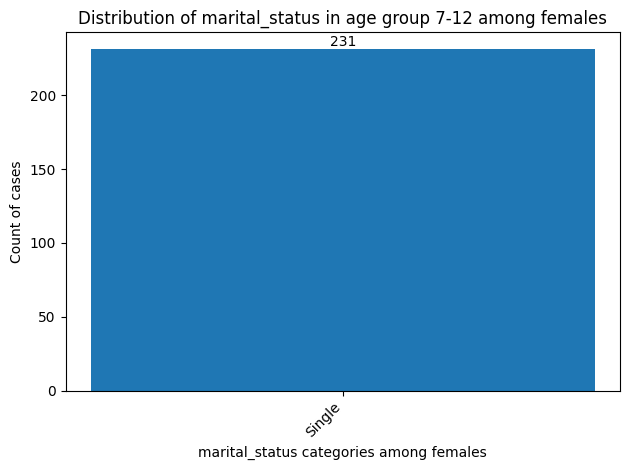

In [467]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [468]:
female_probabilities = female_series / sum(female_series)

In [469]:
female_probabilities

marital_status
Single    1.0
Name: marital_status, dtype: float64

In [470]:
female_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'female')

In [471]:
data_age_group_7_12.loc[female_null_mask, variable] = np.random.choice(list(female_probabilities.index), size=female_null_mask.sum(), p=list(female_probabilities.values))


######male

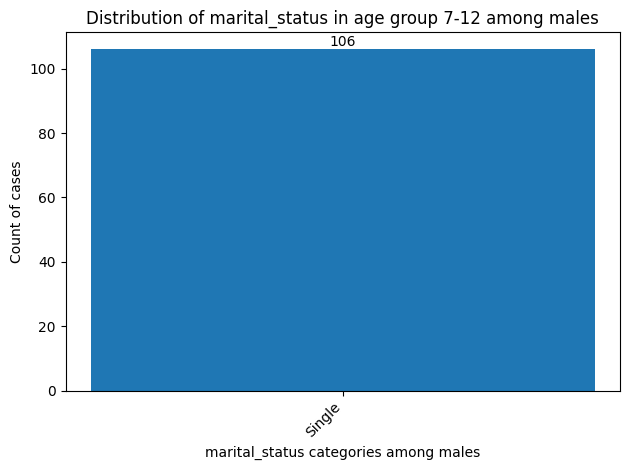

In [472]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

In [473]:
male_probabilities = male_series / sum(male_series)

In [474]:
male_probabilities

marital_status
Single    1.0
Name: marital_status, dtype: float64

In [475]:
male_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'male')

In [476]:
data_age_group_7_12.loc[male_null_mask, variable] = np.random.choice(list(male_probabilities.index), size=male_null_mask.sum(), p=list(male_probabilities.values))


#####Summary

In [477]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].groupby('gender')[variable].value_counts()
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

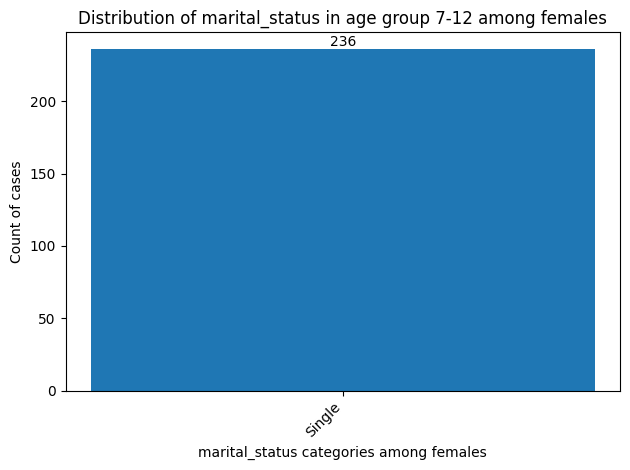

In [478]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

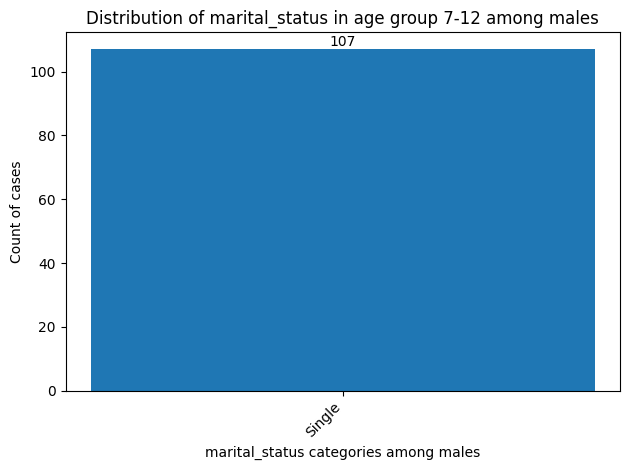

In [479]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

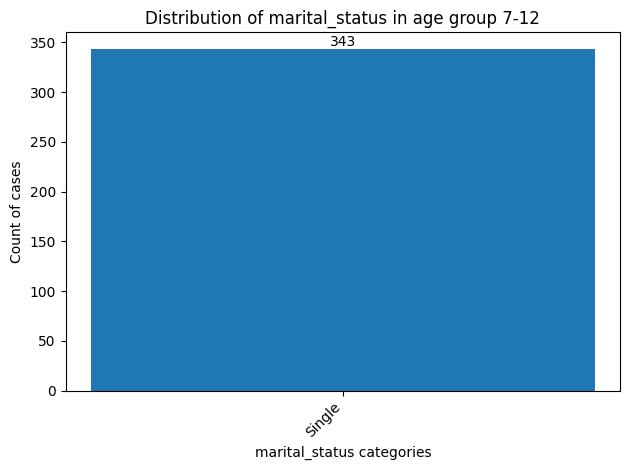

In [480]:
create_bar_plot(data_age_group_7_12[variable].value_counts().index,
                data_age_group_7_12[variable].value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - reason_of_attack_count

In [481]:
variable = 'reason_of_attack_count'

In [482]:
display_info(data_age_group_7_12, [variable])

['reason_of_attack_count']
1

Mode:
0    1.0
Name: reason_of_attack_count, dtype: float64

NaN count: 85

Unique values len:
4

Unique values:
[ 1. nan  2.  3.]

Value counts:
1.0    204
2.0     49
3.0      5
Name: reason_of_attack_count, dtype: int64



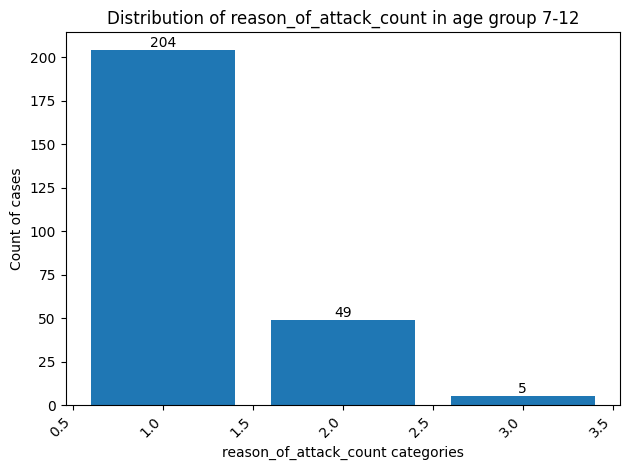

In [483]:
create_bar_plot(data_age_group_7_12_raw[variable].dropna().value_counts().index,
                data_age_group_7_12_raw[variable].dropna().value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####gender

In [484]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].dropna().groupby('gender')[variable].value_counts()


In [485]:
value_counts_df

gender  reason_of_attack_count
female  1.0                       144
        2.0                        36
        3.0                         2
male    1.0                        60
        2.0                        13
        3.0                         3
Name: reason_of_attack_count, dtype: int64

In [486]:
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

######female

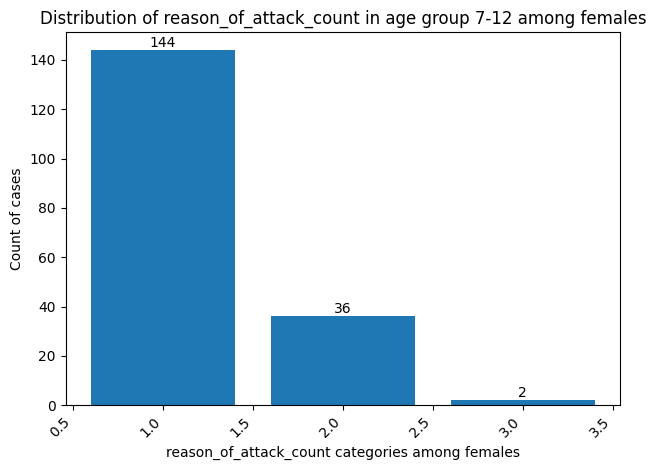

In [487]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [488]:
female_probabilities = female_series / sum(female_series)

In [489]:
female_probabilities

reason_of_attack_count
1.0    0.791209
2.0    0.197802
3.0    0.010989
Name: reason_of_attack_count, dtype: float64

In [490]:
female_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'female')

In [491]:
data_age_group_7_12.loc[female_null_mask, variable] = np.random.choice(list(female_probabilities.index), size=female_null_mask.sum(), p=list(female_probabilities.values))


######male

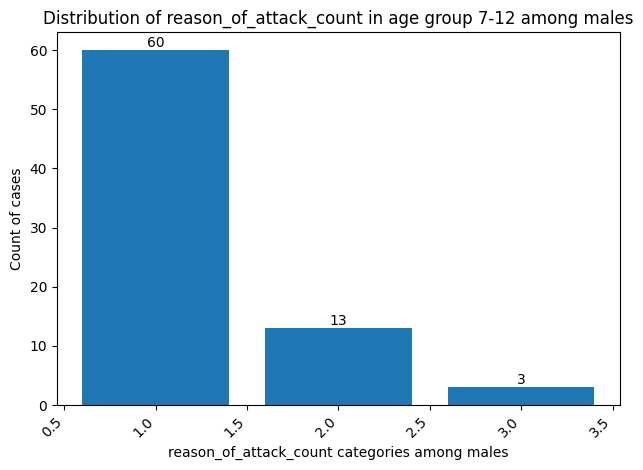

In [492]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

In [493]:
male_probabilities = male_series / sum(male_series)

In [494]:
male_probabilities

reason_of_attack_count
1.0    0.789474
2.0    0.171053
3.0    0.039474
Name: reason_of_attack_count, dtype: float64

In [495]:
male_null_mask = (data_age_group_7_12[variable].isnull()) & (data_age_group_7_12['gender'] == 'male')

In [496]:
data_age_group_7_12.loc[male_null_mask, variable] = np.random.choice(list(male_probabilities.index), size=male_null_mask.sum(), p=list(male_probabilities.values))


#####Summary

In [497]:
value_counts_df = data_age_group_7_12[[variable, 'gender']].groupby('gender')[variable].value_counts()
df = pd.Series(value_counts_df).unstack(level=0)

# Rozdzielenie DataFrame na serie dla płci męskiej i żeńskiej
male_series = value_counts_df['male']
female_series = value_counts_df['female']

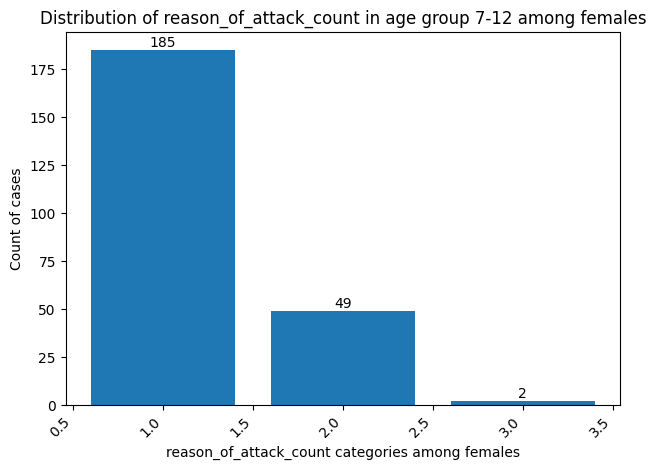

In [498]:
create_bar_plot(female_series.index,
                female_series.values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

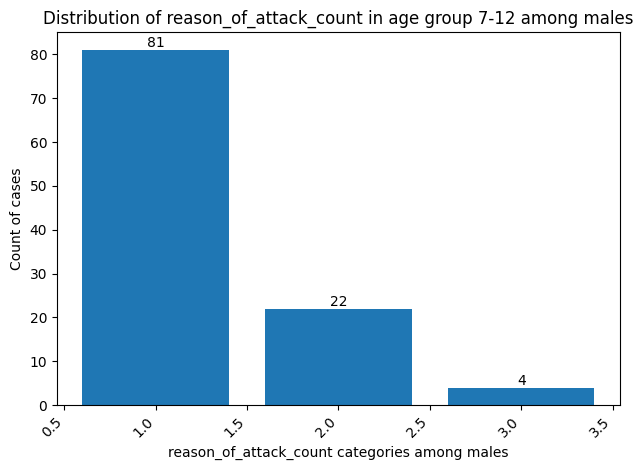

In [499]:
create_bar_plot(male_series.index,
                male_series.values,
                variable + ' categories' + ' among males',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                x_rotation=45)

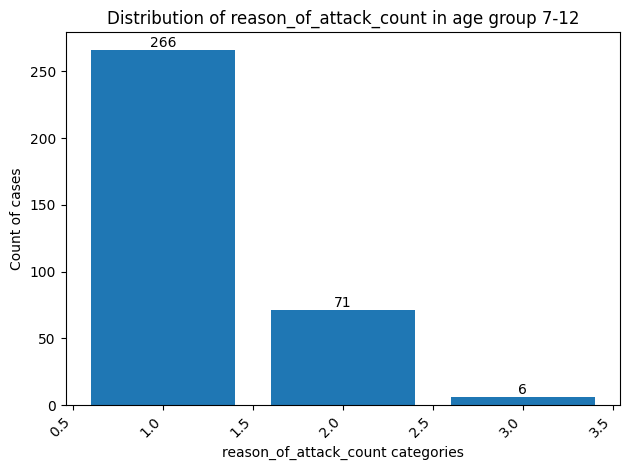

In [500]:
create_bar_plot(data_age_group_7_12[variable].value_counts().index,
                data_age_group_7_12[variable].value_counts().values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#### data_age_group_7_12_reasons_of_attack

In [501]:
selected_columns = data_age_group_7_12_reasons_of_attack.columns.tolist()

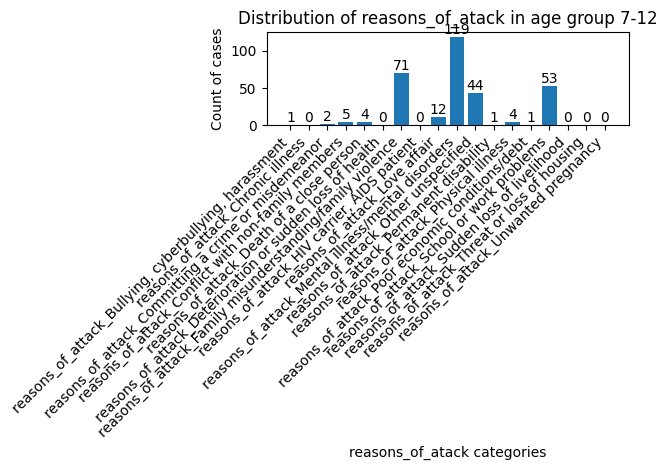

In [502]:
create_bar_plot(selected_columns,
                data_age_group_7_12_reasons_of_attack[selected_columns].sum().tolist(),
                'reasons_of_atack' + ' categories',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group,
                x_rotation=45)

##### gender

In [503]:
female_index = data_age_group_7_12.loc[data_age_group_7_12['gender'] == 'female'].index

In [516]:
female_series = data_age_group_7_12_reasons_of_attack.loc[female_index, selected_columns].sum().tolist()

In [517]:
female_series

[1, 0, 1, 6, 2, 0, 53, 0, 13, 95, 35, 0, 5, 0, 42, 0, 0, 0]

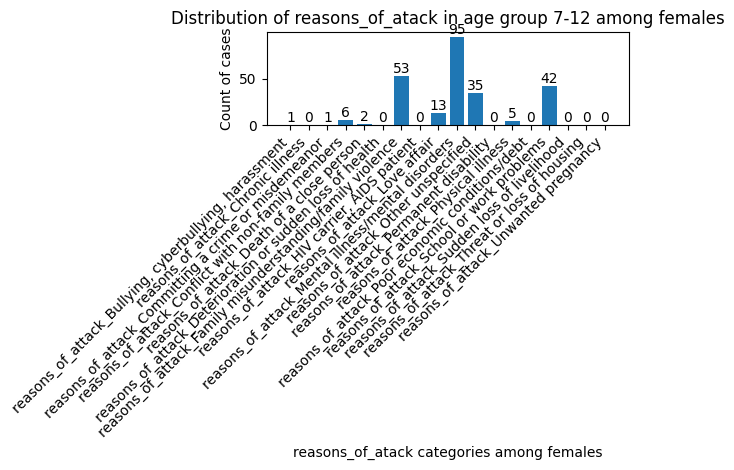

In [518]:
create_bar_plot(selected_columns,
                female_series,
                'reasons_of_atack categories among females',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [507]:
female_probabilities = [x / sum(female_series) for x in female_series]

In [508]:
female_probabilities

[0.0045045045045045045,
 0.0,
 0.0045045045045045045,
 0.018018018018018018,
 0.009009009009009009,
 0.0,
 0.22072072072072071,
 0.0,
 0.04954954954954955,
 0.36936936936936937,
 0.14414414414414414,
 0.0,
 0.018018018018018018,
 0.0,
 0.16216216216216217,
 0.0,
 0.0,
 0.0]

In [511]:
data_age_group_7_12.loc[female_null_mask, variable]

6711      1.0
6949      1.0
8125      1.0
17404     1.0
28313     2.0
36551     1.0
37414     1.0
43035     1.0
45326     1.0
47508     1.0
48124     1.0
51645     1.0
54376     1.0
54668     1.0
57691     1.0
58636     1.0
61614     1.0
64002     1.0
64545     1.0
66194     1.0
68216     2.0
69497     1.0
69992     1.0
70843     1.0
71779     1.0
74859     1.0
78908     1.0
81913     2.0
83359     1.0
85846     2.0
88071     1.0
89098     2.0
90464     1.0
90998     1.0
91590     1.0
91769     1.0
93372     1.0
97056     1.0
98127     1.0
99053     1.0
99223     1.0
100740    2.0
101721    2.0
102249    2.0
103582    1.0
103631    1.0
103654    2.0
103655    1.0
103836    2.0
108449    2.0
110656    2.0
111327    1.0
111806    1.0
113123    2.0
Name: reason_of_attack_count, dtype: float64

In [513]:
variable_values = data_age_group_7_12.loc[female_null_mask, variable]  # Wartości z kolumny

# Lista do przechowywania wylosowanych wartości dla każdej wartości w zmiennej
selected_values = []

# Iteracja przez wartości w zmiennej
for value in variable_values:
    # Losowanie wartości zgodnie z podanymi prawdopodobieństwami
    selected_value = np.random.choice(selected_columns, size=int(value), p=female_probabilities)
    selected_values.append(selected_value)

In [514]:
selected_values

[array(['reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Family misunderstanding/family violence'],
       dtype='<U57'),
 array(['reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Family misunderstanding/family violence',
        'reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Family misunderstanding/family violence'],
       dtype='<U57'),
 array(['reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Mental illness/mental disorders'], dtype='<U57'),
 array(['reasons_of_attack_Mental illness/mental disor

In [515]:
# Iteracja przez indeksy i wartości w kolumnie reason_of_attack_count
for idx, selected_value in zip(female_null_mask.index, selected_values):
    # Iteracja przez wylosowane wartości
    for column_name in selected_value:
        # Ustawienie wartości 1 w odpowiednich kolumnach
        data_age_group_7_12_reasons_of_attack.loc[idx, column_name] = 1
